<a href="https://colab.research.google.com/github/learner-harshit/BCS_Workshop_Apr_20/blob/master/CM_180285.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/bcs-iitk/BCS_Workshop_Apr_20/blob/master/Computational_Modeling/Assignment/CM.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/bcs-iitk/BCS_Workshop_Apr_20/blob/master/Computational_Modeling/Assignment/CM.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://github.com/bcs-iitk/BCS_Workshop_Apr_20/raw/master/Computational_Modeling/Assignment/CM.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In [0]:
# Copyright (c) 2020 Brain and Cognitive Society, IIT Kanpur [ BCS @IITK ]
# Copyright under MIT License, must reference https://github.com/bcs-iitk/BCS_Workshop_Apr_20 if used anywhere else.
# Author: Shashi Kant (http://shashikg.github.io/)

# Assignment 2: Computational Modeling
I hope you guys have gone through the videos, the purpose of first three videos was to teach you about why we build computational model and what it is and how in general we do it. The videos provided after that introduced you to some of the remarkable models of cognition from a historical perspective. In this assignment we will try to build those model computationaly in python. Before going further let me give you a basic gist about how computational modeling is done so as to make it sure that you understood it. So computational modeling basically involves following steps:

* First we study human cognition using some experiments (any psychological or neuro experiment).
* Record human behavior on the given set of stimuli designed for the experiments.
* Based on those behavior conclude some idea about the cognitive processes.
* Then we build a computaional model of that.
* After that we feed the same stimuli to our computational model and predict behavior.
* finally we verify if our model is predicting the same behavior.

Overall we follow the following process:
<img src="https://raw.githubusercontent.com/bcs-iitk/BCS_Workshop_Apr_20/master/Computational_Modeling/Assignment/cm.png" width="90%">



## Question 1: Model of Memory: Atkinson-Shiffrin's Multi-Store Model of Memory

### Description of the model

Recall about Atkinson-Shiffrin's Multi-Store Model of Memory and Serial Position Effect. In this part of the assignment we will try to build that model of memory and will verify it using the serial position effect.
<img src="https://raw.githubusercontent.com/bcs-iitk/BCS_Workshop_Apr_20/master/Computational_Modeling/Assignment/memory.png" width="90%">

While building this model we will make following assumptions:
* Sensory Memory:
 * Only those information, which should be attended will be forwarded to STM.
 * Whether an information should be attended or not will be given.

* Short Term Memory (STM):
 * Holds an item for **20 sec** if its not rehearsed.
 * Capacity of max **7 items**
 * Rehearsal properties:
   * Only those item will be rehearsed which is to be remembered or learned.
   * Whether the item will be stored in LTM or not will depend on its **rehearsal count (RC)**.
   * Randomly decide to store the item to LTM based on the follwing probablity:  $sigmoid(\frac{RC-3150}{630})$. Where; $sigmoid(x) = \frac{1}{1+exp(-x)}$ (There is no evidence for this probability rule, selected arbitrarily)
   * This rehearsal count for each item will be calculated on the basis of **rehearsal speed of STM.**
   * The rehearsal speed of STM will depend on the number of rehearsable item i.e items which are to be remembered.
   * Such that, **rehearsal speed (RS) = (420/num_rehearsable_items)/sec**
   * Therefore, **RC = RS*time**
 * If STM contains 7 items and a new item comes, following will happen:
   * If there are any non-rehearsable item, then it will be removed from STM store and will be replaced by the new item (process is called as Displacement). 
   * If all items are rehearsable, an item will be removed randomly based on equal probality for each item and will be replaced by the new item.
   * Before dumping the removed item it will be checked if it should be kept in LTM or not based on the rehearsal property mentioned above.
* Long Term Memory (LTM):
 * Infinite capacity for infinite time.

Now lets start modeling it!


### Creating the model of the memory

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import choice as randC
from numpy.random import uniform as randU

In [0]:
class MemoryModel:
  class SensoryMemory:
    def __init__(self, attention_store):
      '''
      Arguments:
      attention_store - python list
      '''
      self.attention_store = attention_store

    def input(self, item):
      '''
      Implement this function to check if the input item should be attended or not.
      If the item is in self.attention_filter then it should be attended otherwise rejected
      Should return True if attended otherwise False
      Use attn_flag variable to store your True or False value
      '''

      ## Start your code here >>>>>>>>>>>>>>>>>>>>>>>
      attn_flag = (item in self.attention_store)
      ## End your code here >>>>>>>>>>>>>>>>>>>>>>>>>

      return attn_flag

  class STM:
    def __init__(self, capacity=7, duration=20):
      self.capacity = capacity
      self.duration = duration
      self.max_rehearsal_speed = 420
      self.store = []                 # 'pytho list': this should contain the items stored in STM 
      self.rehearsal_flag = []        # 'pytho list': this should contain 0 for non rehearsalable item and 1 for rehearsable item.
      self.rehearsal_count = []       # 'pytho list': this should contain the rehearsal count performed by respective items
      self.last_update_time = 0       #  last time the memory was updated
      self.input_time = []            # 'pytho list': input time of the item

    def input(self, item, time, LTM_Link, r_flag=0):
      '''
      Implement this function to achieve the task of the input processing of STM
      Should do the following function:
       - Check if the number of items currently present in STM i.e. length of self.store
       - If numbers of items are 7, forget one item using the condition described above.
       - Store the removed item in LTM using "LTM_Link" decide using the probability given above. [Hint: LTM_Link.input(item)]
       - Store the new item in self.store and its rehearsable flag "r_flag" in self.rehearsal_flag and intialise its rehearsal_count to "0"
       - Store the current time "time" into self.input_time at respective position of new item
      
      Arguments:
      item - the input item which is to be stored
      r_flag - rehearsable flag
      LTM_Link - var linking the LTM of the memory
      time - current time
      '''

      ## Start your code here >>>>>>>>>>>>>>>>>>>>>>>
      
      if(len(self.store)==self.capacity):
        old_count = 0 # no of rehearsable items.
        non_rehearsable = [] #array to store the index of non-rehearsable items
        for i in range(self.capacity):
          
          if(self.rehearsal_flag[i]==1):
            old_count = old_count + 1
          else:
            non_rehearsable.append(i)
        
        if(old_count==self.capacity):
        
          index=np.random.choice(self.capacity) #randomly choose an index to remove
          RC=self.rehearsal_count[index]
          x=(RC-3150)/630
          sigmoidx=1/(1+np.exp(-x)) # probability to check if the item needs to be stored in LTM
          flag=np.random.choice([0,1], p=[1-sigmoidx,sigmoidx])
          if(flag==1):
            LTM_Link.input(self.store[index])
          self.store[index] = item
          self.rehearsal_flag[index] = r_flag
          self.input_time[index] = time
          self.rehearsal_count[index]=0            
        
        else:

          index=np.random.choice(non_rehearsable)
          RC=self.rehearsal_count[index]
          x=(RC-3150)/630 
          sigmoidx=1/(1+np.exp(-x)) 
          flag=np.random.choice([0,1], p=[1-sigmoidx,sigmoidx])
          if(flag==1):
            LTM_Link.input(self.store[index])
          self.store[index] = item
          self.rehearsal_flag[index] = r_flag
          self.input_time[index] = time
          self.rehearsal_count[index]=0
      
      else:
        
        self.store.append(item)
        self.input_time.append(time)
        self.rehearsal_flag.append(r_flag)
        self.rehearsal_count.append(0)
      
      ## End your code here >>>>>>>>>>>>>>>>>>>>>>>>>

      return

    def retrieve(self):
      '''
      Implement this function to retrieve the item stored in short term memory

      Return:
      items - List of item stored in STM
      '''

      ## Start your code here >>>>>>>>>>>>>>>>>>>>>>>
      items = self.store
      ## End your code here >>>>>>>>>>>>>>>>>>>>>>>>>

      return items

    def update(self, time, LTM_Link):
      '''
      Implement this function to update the items stored in STM.
      Should do the following functions:
       - for rehearsable items update self.rehearsal_count of each items using the current time "time" and self.last_update_time
       - note extra count should be added to the previous one.
       - for non rehearsable item its rehearsal_count will remain zeros
       - update self.input_time for all rehearsable item to current time "time" (because the item is rehearsed)
       - update self.last_update_time
       - If any non rehearsable item's storage duration becomes >= self.duration, remove that element from self.store
       - Store the removed item in LTM using "LTM_Link" decide using the probability given above.

      '''

      ## Start your code here >>>>>>>>>>>>>>>>>>>>>>>
      count=0
      remove=[]
      if(len(self.store)!=0):
       for i in range(len(self.store)): 
         if(self.rehearsal_flag[i]==1):
           count = count + 1
       for i in range(len(self.store)): 
         if(self.rehearsal_flag[i]==1):
           RS=self.max_rehearsal_speed/count
           RC=RS*(time-self.last_update_time)
           self.rehearsal_count[i]=self.rehearsal_count[i]+RC
           self.input_time[i]=time
         else:
           if(time-self.input_time[i]>=self.duration):
             remove.append(i)  
             x=(self.rehearsal_count[i]-3150)/630 
             sigmoidx=1/(1+np.exp(-x))
             flag=np.random.choice([0,1], p=[1-sigmoidx,sigmoidx])
             if(flag):
               LTM_Link.input(self.store[i])
             
       
       for i in sorted(remove, reverse=True):
          self.store.pop(i)
          self.rehearsal_count.pop(i)
          self.input_time.pop(i)
          self.rehearsal_flag.pop(i) 

      
      '''
      print(time,' secs')
      print('store:',self.store)
      print('R flag:',self.rehearsal_flag)
      print('RC:',self.rehearsal_count)        
      '''
      
      self.last_update_time = time
      ## End your code here >>>>>>>>>>>>>>>>>>>>>>>>>

      return

    def stop_rehearsal(self):
      '''
      set rehearsal_flag of all the item to "0"
      '''

      ## Start your code here >>>>>>>>>>>>>>>>>>>>>>>
      for i in range(len(self.store)):
        self.rehearsal_flag[i]=0
      ## End your code here >>>>>>>>>>>>>>>>>>>>>>>>>

      return

  class LTM:
    def __init__(self):
      self.store = []

    def input(self, item):
      '''
      This function should store the new item into LTM store i.e. self.store
      '''

      ## Start your code here >>>>>>>>>>>>>>>>>>>>>>>
      self.store.append(item)
      ## End your code here >>>>>>>>>>>>>>>>>>>>>>>>>

      return

    def retrieve(self):
      '''
      Implement this function to retrieve the item stored in long term memory

      Return:
      items - List of item stored in LTM
      '''

      ## Start your code here >>>>>>>>>>>>>>>>>>>>>>>
      items=[]
      items=self.store
      ## End your code here >>>>>>>>>>>>>>>>>>>>>>>>>

      return items

  def __init__(self, attention_store, capacity=7, duration=20):
    self.SM_Link = self.SensoryMemory(attention_store=attention_store)
    self.STM_Link = self.STM(capacity=7, duration=20)
    self.LTM_Link = self.LTM()

  def input(self, item, time, remember=False):
    attn_flag = self.SM_Link.input(item)

    if attn_flag:
     self.STM_Link.update(time, self.LTM_Link)
     self.STM_Link.input(item, time, self.LTM_Link, int(remember))
     
 
  def retrieve(self, time):
    self.STM_Link.update(time, self.LTM_Link)
    STM_items = self.STM_Link.retrieve()
    LTM_items = self.LTM_Link.retrieve()

    return list(STM_items) + list(LTM_items)

  def stop_rehearsal(self):
    self.STM_Link.stop_rehearsal()

  def erase(self):
    '''
    To forget all the stored items
    '''
    self.STM_Link = STM(capacity=7, duration=20)
    self.LTM_Link = LTM()


### Testing the memory model
To test the basic working of the model.

In [105]:
attention_store = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

memory = MemoryModel(attention_store, capacity=7, duration=20)

input_data = ['B', 'A', 'C', 'E', 'F', 'R']
remember_flag = [False, True, False, False, True, True]
input_time = [0, 5, 10, 15, 20, 25]

for i in range(len(input_data)):
  memory.input(input_data[i], input_time[i], remember = remember_flag[i])

print("\nRecall at time 30 secs:") # test of STM duration
print(memory.retrieve(30))

memory.stop_rehearsal()
print("\nRecall at time 40 secs:") # test of STM rehearsal
print(memory.retrieve(40))

memory.stop_rehearsal()
print("\nRecall at time 50 secs:") # test of LTM
print(memory.retrieve(50))


Recall at time 30 secs:
['A', 'E', 'F']

Recall at time 40 secs:
['A', 'F']

Recall at time 50 secs:
['A']


Expected output:


```
Recall at time 30 secs:
['A', 'E', 'F']

Recall at time 40 secs:
['A', 'F']

Recall at time 50 secs:
['A']
```



### Serial position effect experiment
Testing the serial position effect experiment

In [0]:
def load_data_spe():
  !wget --no-verbose --no-check-certificate https://github.com/bcs-iitk/BCS_Workshop_Apr_20/raw/master/Computational_Modeling/Assignment/data/memory/stimuli.npy -O stimuli.npy
  !wget --no-verbose --no-check-certificate https://github.com/bcs-iitk/BCS_Workshop_Apr_20/raw/master/Computational_Modeling/Assignment/data/memory/remember_flag.npy -O remember_flag.npy
  !wget --no-verbose --no-check-certificate https://github.com/bcs-iitk/BCS_Workshop_Apr_20/raw/master/Computational_Modeling/Assignment/data/memory/input_time.npy -O input_time.npy
  !wget --no-verbose --no-check-certificate https://github.com/bcs-iitk/BCS_Workshop_Apr_20/raw/master/Computational_Modeling/Assignment/data/memory/attention_store.npy -O attention_store.npy

  stimuli = np.load("stimuli.npy")
  remember_flag = np.load("remember_flag.npy")
  input_time = np.load("input_time.npy")
  attention_store = np.load("attention_store.npy")

  return attention_store, stimuli, remember_flag, input_time

In [107]:
attention_store, stimuli, remember_flag, input_time = load_data_spe()

2020-04-10 15:01:11 URL:https://raw.githubusercontent.com/bcs-iitk/BCS_Workshop_Apr_20/master/Computational_Modeling/Assignment/data/memory/stimuli.npy [10128/10128] -> "stimuli.npy" [1]
2020-04-10 15:01:14 URL:https://raw.githubusercontent.com/bcs-iitk/BCS_Workshop_Apr_20/master/Computational_Modeling/Assignment/data/memory/remember_flag.npy [1378/1378] -> "remember_flag.npy" [1]
2020-04-10 15:01:17 URL:https://raw.githubusercontent.com/bcs-iitk/BCS_Workshop_Apr_20/master/Computational_Modeling/Assignment/data/memory/input_time.npy [10128/10128] -> "input_time.npy" [1]
2020-04-10 15:01:19 URL:https://raw.githubusercontent.com/bcs-iitk/BCS_Workshop_Apr_20/master/Computational_Modeling/Assignment/data/memory/attention_store.npy [752/752] -> "attention_store.npy" [1]


In [0]:
def run_single_exp(attention_store, input_data, remember_flag, input_time):
  ''' 
  Implement this function to run the experiment on a single stimuli. 
  Use help from the model testing example.
  model should retrieve the stored item at time = input_time[-1] + 1

  Arguments:
  attention_store - python list of items which are allowed to attend
  input_data - python list of input items (subset of attenstion store)
  remember_flag - python list of remember flag i.e. whether the input item allowed to rehearse or not; for this exp all are True.
  input_time - python list of time at which input data are fed. intervals of 5 secs.

  Return:
  recall_idx - numpy array of size equal to the length of input_data, 
               if the item at index 'i' i.e. input_data[i] is sucessfully recalled recall_idx[i] = 1 otherwise 0
               Hint: use a.index(item) to find the index of an item in a list s.
  '''

  # Start your code here >>>>>>>>>>>>>>>>>>>>>>>
  recall_idx = np.zeros(len(input_data))
  
  memory = MemoryModel(attention_store, capacity=7, duration=20)
  
  for i in range(len(input_data)):
    memory.input(input_data[i], input_time[i], remember = remember_flag[i])
  
  recall = memory.retrieve(input_time[-1]+5)
  #print(input_data,recall) 
  
  for i in range(len(recall)):
    ind=input_data.index(recall[i])
    recall_idx[ind] = 1
 ## End your code here >>>>>>>>>>>>>>>>>>>>>>>>>

  return recall_idx

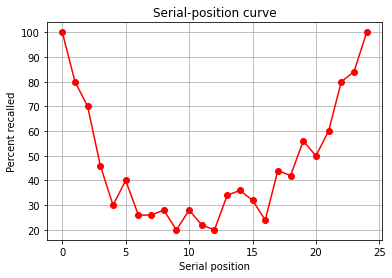

In [115]:
# Run the experiment for all stimuli set and plot average

recall_perc = np.zeros(stimuli.shape[1])
N = stimuli.shape[0]

for i in range(N):
  recall_perc += run_single_exp(list(attention_store), list(stimuli[i]), list(remember_flag[i]), list(input_time[i]))

recall_perc /= N/100

plt.plot(recall_perc, 'o-r')
plt.ylabel('Percent recalled')
plt.xlabel('Serial position')
plt.grid()
plt.title("Serial-position curve")
plt.show()

Expected output: (Not exact but pattern should be more or like this)

<img src="https://raw.githubusercontent.com/bcs-iitk/BCS_Workshop_Apr_20/master/Computational_Modeling/Assignment/spc.png">



## Question 2: Model of Attention: Feature Integration Theory (FIT)
In this part, we will try to build the computational model of attention based on feature integration theory. After building the model, we will verify it on the two kinds of visual search task i.e. parallel (feature) search and serial (conjunction) search.

### Description of the model

Lets briefly recall what features integration theory says. So according FIT when perceiving a visual stimulus, basic features such as color, shape, motion, depth, etc are attended early in the process, automatically and parallel. Parallel means all the features across the whole image is identified simultaneously. While the complete objects are identified in the later stage of processing which combines these features to finally define the object. So this combining of features is done serially.
 
![FIT](https://4.bp.blogspot.com/-iBYucws87tM/Thu7A_DLMEI/AAAAAAAAAAQ/GANIhYmUSVk/s1600/FIT.gif)

The whole process can be broken down into following steps:
* Stimulus input,
* Preattentive Stage:
  * Creation of feature maps for different basic features, for simplicity we will create feature maps for just two kinds of features i.e. color and shape.
  * So, in this stage model will find the location of the features of the target image present in the search image.
* Focused Attention Stage::
  * In this stage, a master map of location is created based on combining all the feature maps, you get a single map which gives the location on the search image where different features have been detected.
* Perception of the object.

#### Feature (Parallel) Search:
In this kind of visual search, target is defined only by only one feature i.e. color or shape. Therefore, these are fast and are done pre-attentivly directly using the feature map.

#### Conjunction (Serial) Search:
In this kind of visual search, target is defined by multiple features and are identified serially. Therefore, these are slow and are done using the master map of location.

<img src="https://slideplayer.com/slide/16537272/96/images/16/Visual+search+X+X+X+X+O+X+O+X+X+X+X+X+X+O+X+X+X+X+O+O+X+X+O+X+X+X+X.jpg" width="80%">

### Creating the model

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import choice as randC
import cv2

In [0]:
#####################################
##   Do not touch this part        ##
##   This has been done for you    ##
#####################################

def get_color_map(search_img, tar_img, grid_size=(5, 5), grid_length=30):
  img_rgb = np.copy(tar_img)
  img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
  thresh = cv2.adaptiveThreshold(img_gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
  ret,thresh = cv2.threshold(img_gray,160,255,0)
  contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  M = cv2.moments(contours[1])
  cx = int(M['m10']/M['m00'])
  cy = int(M['m01']/M['m00'])

  th_val = cv2.cvtColor(img_rgb[cx, cy].reshape((1, 1, 3)), cv2.COLOR_BGR2GRAY)
  th_val = th_val.reshape(1)

  img_rgb = np.copy(search_img)
  img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
  ret,th1 = cv2.threshold(img_gray,th_val[0]-5,255,0)
  ret,th2 = cv2.threshold(img_gray,th_val[0]+5,255,0)
  thresh = th2-th1
  contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  c_map = np.zeros(grid_size)

  for cnt in contours:
    M = cv2.moments(cnt)
    cy = int(M['m10']/M['m00'])
    cx = int(M['m01']/M['m00'])

    c_map[int(cx/grid_length), int(cy/grid_length)] = 1

  return c_map

#####################################
##   Do not touch this part        ##
##   This has been done for you    ##
#####################################

def get_shape_map(search_img, tar_img, grid_size=(5, 5), grid_length=30):
  img_rgb = np.copy(search_img)
  img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
  template = cv2.cvtColor(tar_img, cv2.COLOR_BGR2GRAY)
  w, h = template.shape[::-1]

  res = cv2.matchTemplate(img_gray,template,cv2.TM_CCOEFF_NORMED)
  threshold = 0.99
  loc = np.where( res >= threshold)

  s_map = np.zeros(grid_size)

  for pt in zip(*loc[::-1]):
    cx, cy = (int((pt[1]+grid_length/3)/grid_length), int((pt[0]+grid_length/3)/grid_length))
    s_map[cx, cy] = 1

  return s_map

#####################################
##   Do not touch this part        ##
##   This has been done for you    ##
#####################################

In [0]:
class FIT:
  def __init__(self, grid_size=(5, 5), grid_length=30):
    self.map_size = grid_size
    self.grid_length = grid_length
    self.color_map = np.zeros(grid_size)
    self.shape_map = np.zeros(grid_size)
    self.master_map = np.zeros(grid_size)
    self.fxn2ms = 320 # approximate value to convert fixation number to millisec

  def reset_maps(self):
    '''
    This should reset all the maps to zeros
    '''

    ## Start your code here >>>>>>>>>>>>>>>>>>>>>>>
    self.color_map = np.zeros(self.map_size)
    self.shape_map = np.zeros(self.map_size)
    self.master_map = np.zeros(self.map_size)
    ## End your code here >>>>>>>>>>>>>>>>>>>>>>>>>

    return

  def gen_feature_map(self, search_img, tar_img):
    '''
    Generate the feature maps i.e. self.color_map and self.shape_map using the function get_color_map() and get_shape_map()
    '''

    ## Start your code here >>>>>>>>>>>>>>>>>>>>>>>
    self.color_map = get_color_map(search_img, tar_img)
    self.shape_map = get_shape_map(search_img, tar_img)
    ## End your code here >>>>>>>>>>>>>>>>>>>>>>>>>

    return

  def gen_master_map(self):
    '''
    Implement this function to generate the master_map in self.master_map
    self.master_map - should be the overall attention map i.e. '1' at the places where features where detected. 
    doesn't matter if its a shape feature or color feature.
    '''

    ## Start your code here >>>>>>>>>>>>>>>>>>>>>>>
    for i in range(self.map_size[0]):
      
      for j in range(self.map_size[1]):
        
        if(self.color_map[i][j] == 1 or self.shape_map[i][j] == 1):
          
          self.master_map[i][j]=1
    ## End your code here >>>>>>>>>>>>>>>>>>>>>>>>>

    return

  def visual_search(self, search_img, tar_img):
    '''
    Implement this function to perform the visual search task
    Should do the following things:
     - at first reset the feature map and master map 
     - gen_feature_map
     - check if there is single object in any of the feature map? If yes, no need to attend and create attention map | Hint: single => only one position with value = '1'
       simply return the grid index of the target and reaction_time; reaction_time = fxn_number*self.fxn2ms | Hint: in this case take fxn_number = 1
     - If single object is not in both feature maps =>> It's conjunction search, gen the master map integrating both features.
     - Now, randomly select the points in master_map which have value = '1' i.e. the places were the model will attend to recognise object.
       At each attended position check if both features are present or not?
     - Keep this running in a loop till you find the object position i.e. where both features are present.
     - Note: do not visit the same position again, do not visit the position which have value = '0'
     - Also, count the total number of iterations it took to find the object, and take that as the fxn_number.
     - Return the grid_idx and reaction_time

    Return:
    RT - reaction time = fxn_number*self.fxn2ms
    tar_idx = position of the target object
    '''

    ## Start your code here >>>>>>>>>>>>>>>>>>>>>>>
    self.reset_maps()
    self.gen_feature_map(search_img, tar_img)
    fxn_number = 0
    count_color,count_shape = 0,0
    for i in range(self.map_size[0]):
      for j in range(self.map_size[1]):
        if(self.color_map[i][j]==1):
          count_color = count_color + 1
        if(self.shape_map[i][j]==1):
          count_shape = count_shape + 1
    
    if(count_color == 1 or count_shape == 1):
      fxn_number = 1
      RT = fxn_number*self.fxn2ms
      if(count_color==1):
       for i in range(5):
        for j in range(5):
          if(self.color_map[i][j]==1):
            tar_idx=(i,j)
      else:
       for i in range(self.map_size[0]):
        for j in range(self.map_size[1]):
          if(self.shape_map[i][j]==1):
           tar_idx=(i,j)
    else:
      self.gen_master_map()
      x=np.asarray(np.where(self.master_map==1)).T 
      c=1
      while(c==1):
        fxn_number = fxn_number + 1
        index=np.random.choice(len(x))
        if(self.color_map[x[index][0]][x[index][1]]==1 and self.shape_map[x[index][0]][x[index][1]]==1 ):
          c=0
          RT = fxn_number*self.fxn2ms
          tar_idx=(x[index][0],x[index][1])
        x=np.delete(x,index,0)
        
        
   ## End your code here >>>>>>>>>>>>>>>>>>>>>>>>>

    return tar_idx, RT

### Load visual search data

In [0]:
def load_data_vs():
  !wget --no-verbose --no-check-certificate https://github.com/bcs-iitk/BCS_Workshop_Apr_20/raw/master/Computational_Modeling/Assignment/data/fit/conjunction_search_img.npy -O conjunction_search_img.npy
  !wget --no-verbose --no-check-certificate https://github.com/bcs-iitk/BCS_Workshop_Apr_20/raw/master/Computational_Modeling/Assignment/data/fit/conjunction_target_img.npy -O conjunction_target_img.npy
  !wget --no-verbose --no-check-certificate https://github.com/bcs-iitk/BCS_Workshop_Apr_20/raw/master/Computational_Modeling/Assignment/data/fit/feature_search_img.npy -O feature_search_img.npy
  !wget --no-verbose --no-check-certificate https://github.com/bcs-iitk/BCS_Workshop_Apr_20/raw/master/Computational_Modeling/Assignment/data/fit/feature_target_img.npy -O feature_target_img.npy

  conjunction_search_img = np.load("conjunction_search_img.npy")
  conjunction_target_img = np.load("conjunction_target_img.npy")
  feature_search_img = np.load("feature_search_img.npy")
  feature_target_img = np.load("feature_target_img.npy")

  return conjunction_search_img, conjunction_target_img, feature_search_img, feature_target_img

In [120]:
conjunction_search_img, conjunction_target_img, feature_search_img, feature_target_img = load_data_vs()

2020-04-10 15:02:31 URL:https://raw.githubusercontent.com/bcs-iitk/BCS_Workshop_Apr_20/master/Computational_Modeling/Assignment/data/fit/conjunction_search_img.npy [4050128/4050128] -> "conjunction_search_img.npy" [1]
2020-04-10 15:02:35 URL:https://raw.githubusercontent.com/bcs-iitk/BCS_Workshop_Apr_20/master/Computational_Modeling/Assignment/data/fit/conjunction_target_img.npy [2828/2828] -> "conjunction_target_img.npy" [1]
2020-04-10 15:02:37 URL:https://raw.githubusercontent.com/bcs-iitk/BCS_Workshop_Apr_20/master/Computational_Modeling/Assignment/data/fit/feature_search_img.npy [4050128/4050128] -> "feature_search_img.npy" [1]
2020-04-10 15:02:39 URL:https://raw.githubusercontent.com/bcs-iitk/BCS_Workshop_Apr_20/master/Computational_Modeling/Assignment/data/fit/feature_target_img.npy [2828/2828] -> "feature_target_img.npy" [1]


### Run Visual Search
Here, we will test our model on the visual search stimuli.

In [0]:
def run_visual_search_exp(search_stimuli, tar_img, grid_size=(5, 5), grid_length=30):
  '''
  Implement this function to run the visual search experiment on 60 stimuli

  Attribute:
  search_stimuli - (60, 150, 150, 3) numpy array with set of 60 search images of size (150, 150, 3)
                 - images between (0, 20) index have total '7' objects in the search images; objects means target plus distractors
                 - images between (20, 40) index have total '14' objects in the search images
                 - images between (40, 60) index have total '21' objects in the search images

  tar_img - (30, 30, 3) numpy array, contains target image, same target image for all the search images.

  Return:
  RT - python list having 3 elements
     - RT[0] = average reaction time for search images having '7' objects
     - RT[1] = average reaction time for search images having '14' objects
     - RT[2] = average reaction time for search images having '21' objects
  '''

  ## Start your code here >>>>>>>>>>>>>>>>>>>>>>>
  fit=FIT(grid_size=(5,5), grid_length=30)
  RT_all=np.zeros(60, dtype='int')
  RT=np.zeros(3, dtype='int')
  for i in range(60):
    _,RT_all[i] = fit.visual_search(search_stimuli[i], tar_img)
  RT[0]=sum(RT_all[0:20])/20
  RT[1]=sum(RT_all[20:40])/20
  RT[2]=sum(RT_all[40:60])/20
  
    

  ## End your code here >>>>>>>>>>>>>>>>>>>>>>>>>

  return RT

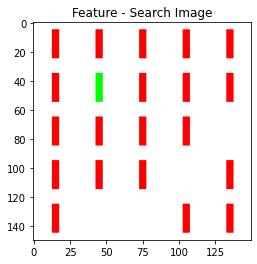

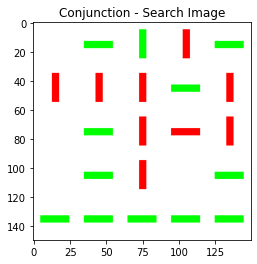

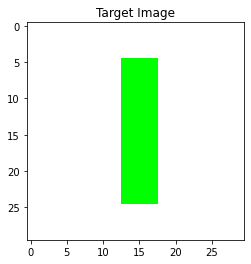

In [122]:
# Displaying images
plt.figure()
plt.imshow(feature_search_img[45])
plt.title("Feature - Search Image")

plt.figure()
plt.imshow(conjunction_search_img[45])
plt.title("Conjunction - Search Image")

plt.figure()
plt.imshow(feature_target_img)
plt.title("Target Image")

plt.show()

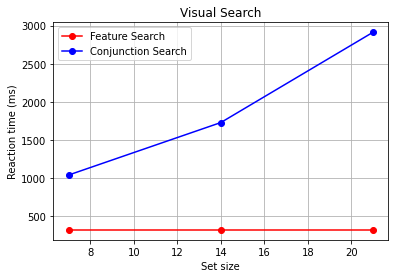

In [124]:
set_size = [7, 14, 21]
RT_C = run_visual_search_exp(conjunction_search_img, conjunction_target_img, grid_size=(5, 5), grid_length=30)
RT_F = run_visual_search_exp(feature_search_img, feature_target_img, grid_size=(5, 5), grid_length=30)

plt.plot(set_size, RT_F, 'o-r', label="Feature Search")
plt.plot(set_size, RT_C, 'o-b', label="Conjunction Search")
plt.ylabel('Reaction time (ms)')
plt.xlabel('Set size')
plt.legend(loc='upper left')
plt.grid()
plt.title("Visual Search")
plt.show()

Expected output: (Not exact but pattern should be more or like this)

<img src="https://raw.githubusercontent.com/bcs-iitk/BCS_Workshop_Apr_20/master/Computational_Modeling/Assignment/vs.png">